In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.stats import sem
import h5py
from pathlib import Path
from collections.abc import Iterable

In [2]:
datapath = Path.cwd() / "data"
figurepath = Path.cwd().parent / "figures/MBL"

In [3]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [4]:
def set_size(width='thesis', fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    aspect_ratio = 1#(5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * aspect_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [5]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2,ddof=1)
    else:
        return np.std(A[:,:,0:n_samples],2,ddof=1)
def disorder_sem(A, n_samples = None):
    if n_samples is None:
        return sem(A,axis=2)
    else:
        return sem(A[:,:,0:n_samples],axis=2)

def symmetrize(arr):
    N = arr.shape[1]
    symarr = np.zeros((arr.shape[0],N//2+1))
    for j in range(0,N//2):
        symarr[:,j] = 0.5*(arr[:,j]+arr[:,N-j-1])
    symarr[:,N//2] = arr[:,N//2]
    return symarr

In [6]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

In [7]:
def model(x,a,b):
    return a*x**b

In [8]:
jobids = []
params = []
data = []
data_nn = []
folders = [datapath/"zz/h = 0",datapath/"zz/h = 1",datapath/"zz/h = 3",datapath/"zz/h = 6",datapath/"zz/h = 9",datapath/"zz/h = 12",datapath/"zz/h = 24", datapath/"zz/h = 18", datapath/"zz/h = 35", datapath/"zz/h = 50",datapath/"zz/h = 75",datapath/"zz/h = 100"]
files = ["combined_file_h{}.jld2".format(h) for h in [0,1,3,6,9,12,24, 18, 35, 50, 75, 100]] 
for (i,file) in enumerate(files):
    with h5py.File(folders[i]/file,"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))
        params.append([f[f["params"][l]][()] for l in range(len(f["params"]))])
folders_nn = [datapath/"zz_nn/h = 0",datapath/"zz_nn/h = 3",datapath/"zz_nn/h = 6",datapath/"zz_nn/h = 9",datapath/"zz_nn/h = 12",datapath/"zz_nn/h = 24"]
files_nn = ["combined_file_h{}.jld2".format(h) for h in [0,3,6,9,12,24]] 
for (i,file) in enumerate(files_nn):
    with h5py.File(folders_nn[i]/file,"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data_nn.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))
        params.append([f[f["params"][l]][()] for l in range(len(f["params"]))])

for  i in range(0,len(files)):
    data[i] = np.concatenate(data[i],axis=0)
    data[i] = rearrange_data(data[i])
for  i in range(0,len(files_nn)):
    data_nn[i] = np.concatenate(data_nn[i],axis=0)
    data_nn[i] = rearrange_data(data_nn[i])

In [9]:
N = 13
hs = [0,3,6,9,12,24]
hs_ext = [0,1,3,6,9,12,24, 18,35,50,75,100]
T = 10 ** np.linspace(-3,6,100)
xcenter = N//2
x = np.arange(0,N//2+1,1)
rvals = np.array([abs(pos-xcenter) for pos in range(0,N)])

In [10]:
res = [disorder_mean(data[i]) for i in range(len(files))]
res_sem = [disorder_sem(data[i]) for i in range(len(files))]
red = list(map(symmetrize,res))
red_sem = list(map(symmetrize,res_sem))

res_nn = [disorder_mean(data_nn[i]) for i in range(len(files_nn))]
res_sem_nn = [disorder_sem(data_nn[i]) for i in range(len(files_nn))]
red_nn = list(map(symmetrize,res_nn))
red_sem_nn = list(map(symmetrize,res_sem_nn))

/home/qd/python-envs/max1/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/qd/python-envs/max1/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [11]:
for i in range(len(files)):
    print(data[i].shape[2])#"  nn ",data_nn[i].shape[2],"\n")

1
500
500
500
500
500
500
500
500
500
500
500


# Coarse Comparison

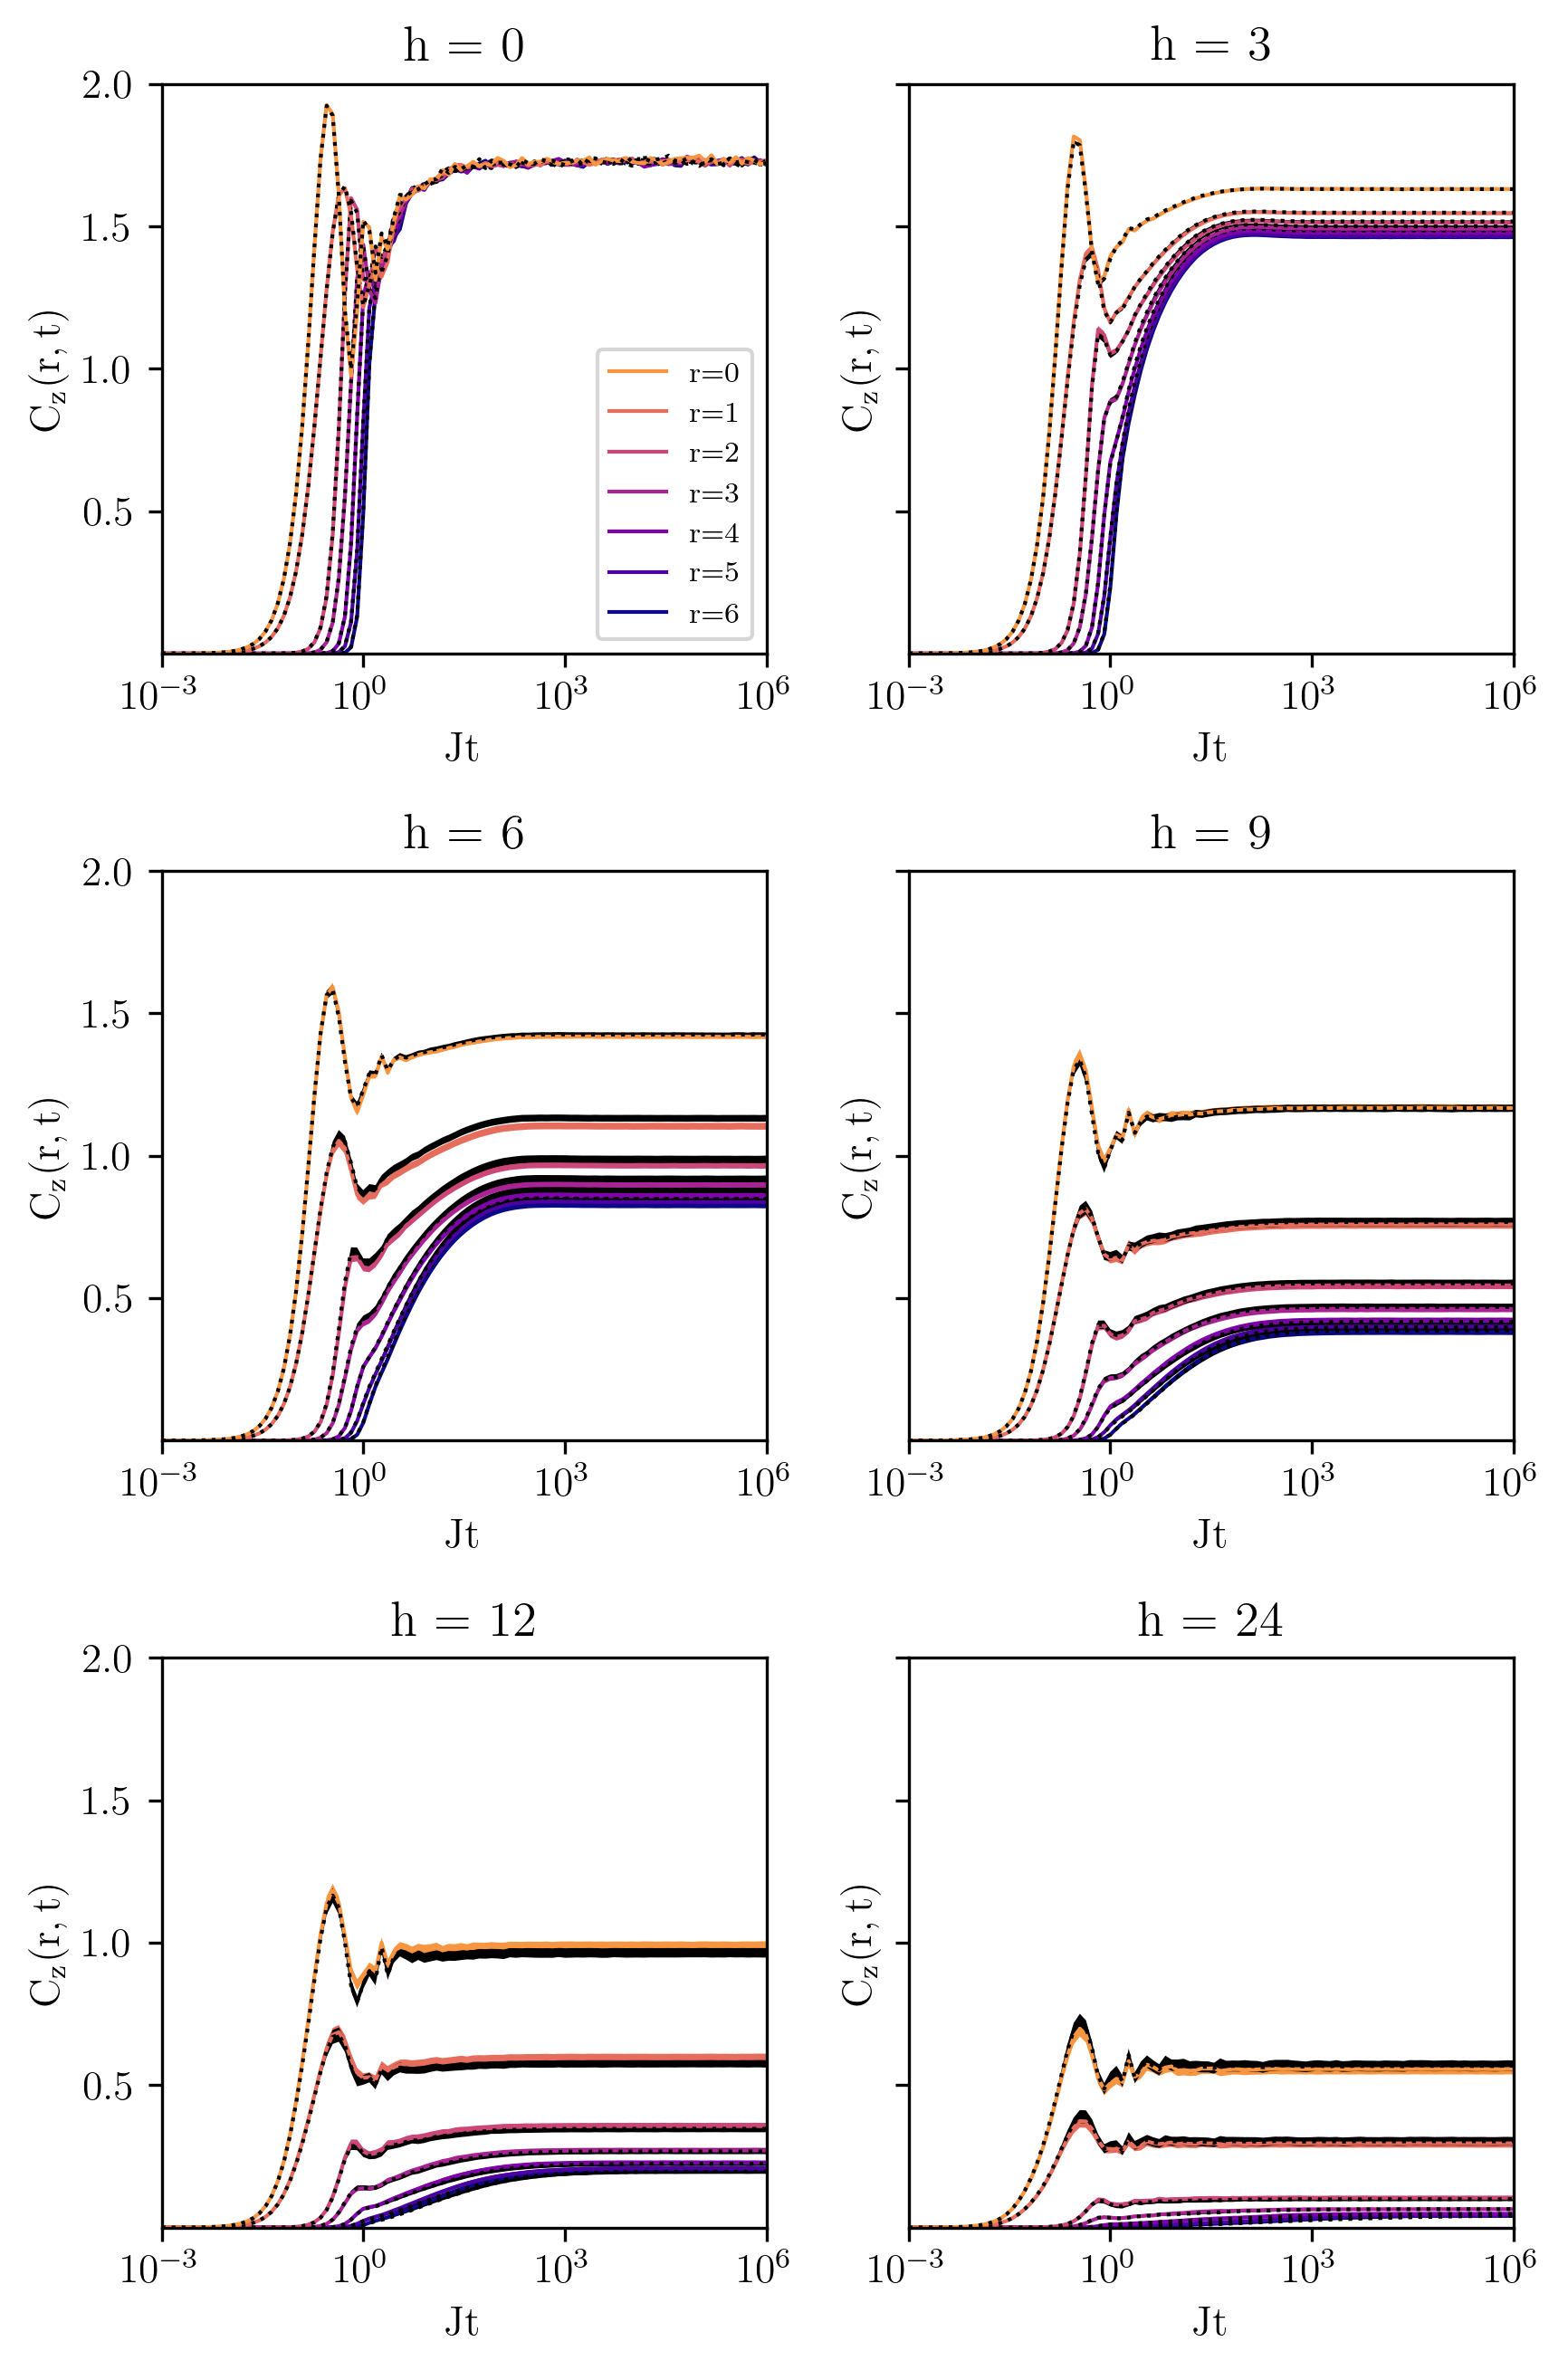

In [12]:
fig, axs = plt.subplots(3,2,figsize=set_size(subplots=(3,2)),dpi = 300,sharey=True)

NUM_COLORS = 13//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


axs[0,0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[0,0].set_xscale("log")
for j in range(0,N//2+1):
    axs[0,0].plot(T,red[0][:,j],label="r={}".format(rvals[j]),lw=1)
    axs[0,0].plot(T,red_nn[0][:,j],ls="dotted",c="black",lw=1)

    axs[0,0].fill_between(T, red[0][:,j]-red_sem[0][:,j], red[0][:,j]+red_sem[0][:,j])
    axs[0,0].fill_between(T, red_nn[0][:,j]-red_sem_nn[0][:,j], red_nn[0][:,j]+red_sem_nn[0][:,j],fc="black")


handles, labels = axs[0,0].get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
axs[0,0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right",fontsize = "x-small")
axs[0,0].set_xlabel(r"Jt")
axs[0,0].set_ylabel(r"$\mathrm{C_z(r,t)}$")
axs[0,0].set_title("h = {}".format(hs[0]))
axs[0,0].set_xlim(1e-3,1e6)
axs[0,0].set_ylim(0,2)

axs[0,1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[0,1].set_xscale("log")
for j in range(0,N//2+1):
    axs[0,1].plot(T,red[1+1][:,j],label="r={}".format(rvals[j]),lw=1)
    axs[0,1].plot(T,red_nn[1][:,j],ls="dotted",c="black",lw=1)

    axs[0,1].fill_between(T, red[1+1][:,j]-red_sem[1+1][:,j], red[1+1][:,j]+red_sem[1+1][:,j])
    axs[0,1].fill_between(T, red_nn[1][:,j]-red_sem_nn[1][:,j], red_nn[1][:,j]+red_sem_nn[1][:,j],fc="black")

axs[0,1].set_xlabel(r"Jt")
axs[0,1].set_title("h = {}".format(hs[1]))
axs[0,1].set_xlim(1e-3,1e6)
axs[0,1].set_ylabel(r"$\mathrm{C_z(r,t)}$")


axs[1,0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[1,0].set_xscale("log")
for j in range(0,N//2+1):
    axs[1,0].plot(T,red[2+1][:,j],label="r={}".format(rvals[j]),lw=1)
    axs[1,0].plot(T,red_nn[2][:,j],ls="dotted",c="black",lw=1)

    axs[1,0].fill_between(T, red[2+1][:,j]-red_sem[2+1][:,j], red[2+1][:,j]+red_sem[2+1][:,j])
    axs[1,0].fill_between(T, red_nn[2][:,j]-red_sem_nn[2][:,j], red_nn[2][:,j]+red_sem_nn[2][:,j],fc="black")

axs[1,0].set_xlabel(r"Jt")
axs[1,0].set_title("h = {}".format(hs[2]))
axs[1,0].set_xlim(1e-3,1e6)
axs[1,0].set_ylabel(r"$\mathrm{C_z(r,t)}$")
axs[1,0].set_ylim(0,2)

###########
## Lowest ##
###########

axs[1,1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[1,1].set_xscale("log")
for j in range(0,N//2+1):
    axs[1,1].plot(T,red[3+1][:,j],label="r={}".format(rvals[j]),lw=1)
    axs[1,1].plot(T,red_nn[3][:,j],ls="dotted",c="black",lw=1)

    axs[1,1].fill_between(T, red[3+1][:,j]-red_sem[3+1][:,j], red[3+1][:,j]+red_sem[3+1][:,j])
    axs[1,1].fill_between(T, red_nn[3][:,j]-red_sem_nn[3][:,j], red_nn[3][:,j]+red_sem_nn[3][:,j],fc="black")

axs[1,1].set_xlabel(r"Jt")
axs[1,1].set_title("h = {}".format(hs[3]))
axs[1,1].set_xlim(1e-3,1e6)
axs[1,1].set_ylabel(r"$\mathrm{C_z(r,t)}$")

axs[2,0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[2,0].set_xscale("log")
for j in range(0,N//2+1):
    axs[2,0].plot(T,red[4+1][:,j],label="r={}".format(rvals[j]),lw=1)
    axs[2,0].plot(T,red_nn[4][:,j],ls="dotted",c="black",lw=1)

    axs[2,0].fill_between(T, red[4+1][:,j]-red_sem[4+1][:,j], red[4+1][:,j]+red_sem[4+1][:,j])
    axs[2,0].fill_between(T, red_nn[4][:,j]-red_sem_nn[4][:,j], red_nn[4][:,j]+red_sem_nn[4][:,j],fc="black")

axs[2,0].set_xlabel(r"Jt")
axs[2,0].set_title("h = {}".format(hs[4]))
axs[2,0].set_xlim(1e-3,1e6)
axs[2,0].set_ylabel(r"$\mathrm{C_z(r,t)}$")
axs[2,0].set_ylim(1e-5,2)


axs[2,1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[2,1].set_xscale("log")
for j in range(0,N//2+1):
    axs[2,1].plot(T,red[5+1][:,j],label="r={}".format(rvals[j]),lw=1)
    axs[2,1].plot(T,red_nn[5][:,j],ls="dotted",c="black",lw=1)

    axs[2,1].fill_between(T, red[5+1][:,j]-red_sem[5+1][:,j], red[5+1][:,j]+red_sem[5+1][:,j])
    axs[2,1].fill_between(T, red_nn[5][:,j]-red_sem_nn[5][:,j], red_nn[5][:,j]+red_sem_nn[5][:,j],fc="black")

axs[2,1].set_xlabel(r"Jt")
axs[2,1].set_title("h = {}".format(hs[5]))
axs[2,1].set_xlim(1e-3,1e6)
axs[2,1].set_ylabel(r"$\mathrm{C_z(r,t)}$")


plt.tight_layout()
#plt.subplots_adjust(wspace=0.05, hspace=0.5)
plt.savefig(figurepath/"gallery_zz.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

(0.001, 10.0)

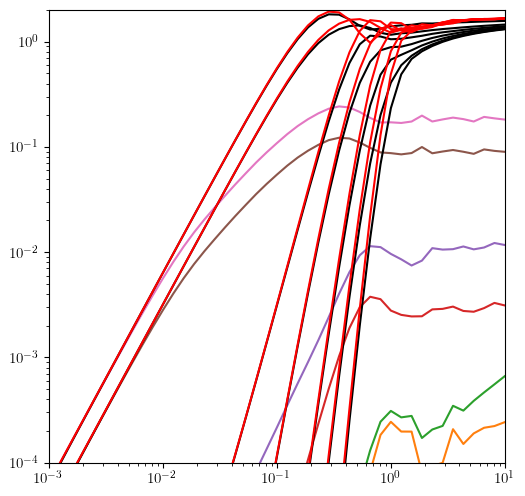

In [13]:
plt.loglog(T,red[-2])
plt.loglog(T,red[2],c="black")
plt.loglog(T,red[0],c="red")
plt.ylim(1e-4,2e0)
plt.xlim(1e-3,1e1)

# Long Time Value Scaling

In [14]:
ltv = np.zeros((len(red),N//2+1))
ltv_err = np.zeros((len(red),N//2+1))
ltv_nn = np.zeros((len(red_nn),N//2+1))
for i in range(len(red)):
    ltv[i] = np.mean(red[i][77:,:],axis=0)
    ltv_err[i] = np.mean(red_sem[i][77:],axis=0)
for i in range(len(red_nn)):
    ltv_nn[i] = np.mean(red_nn[i][77:,:],axis=0)

/home/qd/python-envs/max1/lib/python3.8/site-packages/matplotlib/axes/_base.py:2538: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


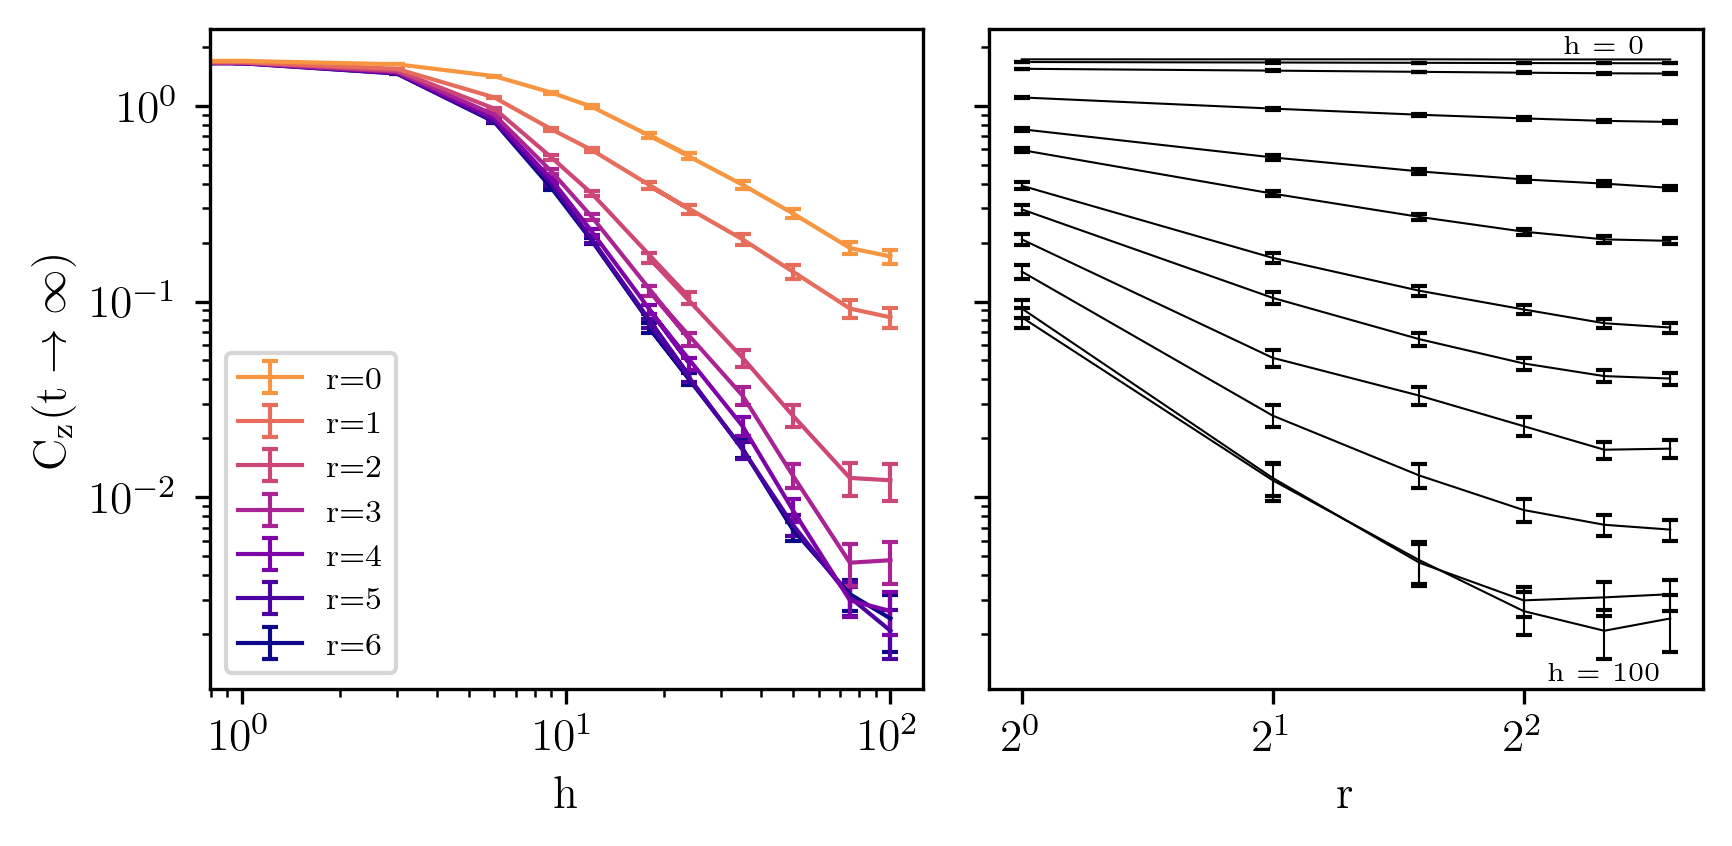

In [15]:
fig, axs = plt.subplots(1,2,figsize=set_size(subplots=(1,2)),dpi = 300,sharey=True)

NUM_COLORS = 13//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


axs[0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
#axs[0].set_xscale("log")
for j in range(0,N//2+1):
    #axs[0].plot(hs[:-1],ltv[:-1,j],label="r={}".format(rvals[j]),lw=1)
    axs[0].errorbar(hs_ext[:],ltv[:,j],yerr=ltv_err[:,j],label="r={}".format(rvals[j]),lw=1,capsize=2)
    #axs[0].plot(hs_ext[5:],model(hs_ext[5:],*popt[j]),c="red",lw=0.5)
    #axs[0].plot(hs[:],ltv_nn[:,j],label="r={}".format(rvals[j]),lw=1,c="red")
    #axs[0,0].plot(T,red_nn[0][:,j],ls="dotted",c="black",lw=1)


handles, labels = axs[0].get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower left",fontsize = "x-small")

axs[0].set_xlabel("h")
axs[0].set_ylabel(r"$\mathrm{C_z(t\rightarrow\infty)}$")
axs[0].set_yscale("log")
axs[0].set_xscale("log")

for ind in range(len(hs_ext)):
    axs[1].errorbar(rvals[0:N//2],ltv[ind,:N//2],yerr=ltv_err[ind,:N//2],capsize=2,label="h={}".format(hs_ext[ind]),c="black",lw=0.5)
    #axs[1].plot(rvals[0:N//2],model(rvals[0:N//2],*popt[ind]),c="black")

#axs[1].set_ylim(1e-2,1e0)
#axs[1].legend(fontsize="x-small")
axs[1].set_xlabel("r")
axs[1].set_yscale("log")
axs[1].set_xscale("log",base=2)
axs[1].text(5,2,"h = 0",ha="center",va="center",fontsize="xx-small")
axs[1].text(5,0.00125,"h = 100",ha="center",va="center",fontsize="xx-small")

plt.tight_layout()
plt.savefig(figurepath/"ltv_decay_zz.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

In [64]:
hs_ext[3:-1]

[6, 9, 12, 24, 18, 35, 50, 75]

In [71]:
popt

[array([78.7164275 , -2.39751422]),
 array([74.13248639, -2.36604455]),
 array([58.20166704, -2.23153739]),
 array([46.7480142 , -2.07404118]),
 array([32.44238348, -1.8170059 ]),
 array([ 7.11739801, -1.00074561]),
 array([ 8.65136958, -0.87008349])]

In [18]:
popt = []
perr = []
for ind in range(len(hs_ext)):
    poptj, pcovj = curve_fit(model,rvals[0:N//2],ltv[ind,:N//2])
    popt.append(poptj)
    perr.append(np.sqrt(np.diag(pcovj)))

In [20]:
popt = []
perr = []
for ind in range(0,N//2+1):
    poptj, pcovj = curve_fit(model,hs_ext[5:-1],ltv[5:-1,ind])
    popt.append(poptj)
    perr.append(np.sqrt(np.diag(pcovj)))